Authors Pablo Soto and Martín Gómez

In [1]:
from random_forest import MyRandomForestRegressor

import numpy as np
import pandas as pd

from sklearn.datasets import (
    make_regression,
    make_friedman1,
    load_diabetes,
    fetch_california_housing
)
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [2]:
samples = [20, 50, 100, 500, 1000, 2000]
variables = [5, 10, 25, 50, 100, 200]

friedman_1_datasets = [
    [
        make_friedman1(
        n_samples=ns,
        n_features=var,
        noise=1.0,
        random_state=42
    ) for ns in samples]
    for var in variables
]

friedman_1_test = [
    make_friedman1(
        n_samples=1000,
        n_features=var,
        noise=1.0,
        random_state=42
) for var in variables]

In [7]:
models = {
    'RF_sklearn': RandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split=2, max_features="sqrt"),
    #'RF_sklearn': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
    'RF_simple': MyRandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split=2, n_features="sqrt", bagging=True, split_criterion="middle"),
}

In [4]:
friedman_1_results = {}

for name, model in tqdm(models.items()):
    friedman_1_results[name] = np.zeros((len(variables), len(samples)))
    # Loop over the 6 datasets
    for i, data_list in enumerate(tqdm(friedman_1_datasets, leave=False)):
        for j, (X, y) in enumerate(tqdm(data_list, leave=False)):
            # Fit the model on this dataset
            model.fit(X, y)

            X_test, y_test = friedman_1_test[i]
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            friedman_1_results[name][i, j] = mse


with open("friedman_1_mse.pkl", "wb") as file:
    pickle.dump(friedman_1_results, file)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

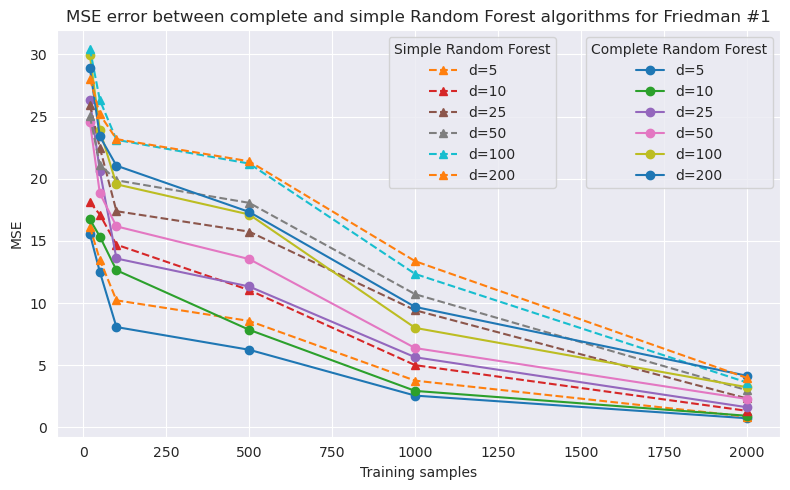

In [ ]:
with open("friedman_1_mse.pkl", "rb") as file:
    friedman_1_results = pickle.load(file)

sklearn_res = friedman_1_results["RF_sklearn"]
middle_res = friedman_1_results["RF_simple"]

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8,5))

# Lists to store handles (Line2D objects) for each method
lines_m1 = []
lines_m2 = []

for i, d_val in enumerate(variables):
    # Method 1, e.g. solid line + 'o' marker
    line_m1, = ax.plot(
        samples,                # x-axis
        sklearn_res[i, :],          # y-values for method1
        marker='o',
        linestyle='-', 
        label=f"d={d_val}"      # label will be used in the legend
    )
    
    # Method 2, e.g. dashed line + '^' marker
    line_m2, = ax.plot(
        samples,
        middle_res[i, :],
        marker='^',
        linestyle='--',
        label=f"d={d_val}"
    )
    
    lines_m1.append(line_m1)
    lines_m2.append(line_m2)

# Now create two separate legends:
#  1) For Method 1
legend_m1 = ax.legend(
    handles=lines_m1,
    labels=[f"d={val}" for val in variables],
    title="Complete Random Forest",
    loc="upper right"
)

# Add the first legend to the axes
ax.add_artist(legend_m1)

#  2) For Method 2
legend_m2 = ax.legend(
    handles=lines_m2,
    labels=[f"d={val}" for val in variables],
    title="Simple Random Forest",
    loc="upper right",
    bbox_to_anchor=(0.7, 1.0),
)

# Label axes, etc.
ax.set_xlabel("Training samples")
ax.set_ylabel("MSE")
ax.set_title("MSE error between complete and simple Random Forest algorithms for Friedman #1")

plt.tight_layout()
plt.savefig("img/friedman1_mse}.png")
plt.show()

In [4]:
cal_data = fetch_california_housing()
X_full, y_full = cal_data.data, cal_data.target

np.random.seed(42)
idx = np.random.choice(X_full.shape[0], size=2000, replace=False)
X_sample = X_full[idx]
y_sample = y_full[idx]

# Add random noise features 
max_total_features = 200
noise_features = np.random.randn(X_sample.shape[0], max_total_features - X_full.shape[1])
X_noisy = np.hstack([X_sample, noise_features])
print("X_noisy shape:", X_noisy.shape)

idx_test = np.random.choice(X_full.shape[0], size=2000, replace=False)
X_test = X_full[idx_test]
y_test = y_full[idx_test]
noise_features = np.random.randn(X_test.shape[0], max_total_features - X_full.shape[1])
X_noisy_test = np.hstack([X_test, noise_features])

X_noisy shape: (2000, 200)


In [5]:
cal_datasets = []
for var in variables:
    same_var_datasets = []
    for ns in samples:
        indices = np.random.choice(X_noisy.shape[0], size=ns, replace=False)
        same_var_datasets.append((X_noisy[indices, :var], y_sample[indices]))
    cal_datasets.append(same_var_datasets)

cal_test = [
    (X_noisy_test[:, :var], y_test) for var in variables
]

In [8]:
cal_results = {}

for name, model in tqdm(models.items()):
    cal_results[name] = np.zeros((len(variables), len(samples)))
    # Loop over the 6 datasets
    for i, data_list in enumerate(tqdm(cal_datasets, leave=False)):
        for j, (X, y) in enumerate(tqdm(data_list, leave=False)):
            # Fit the model on this dataset
            model.fit(X, y)

            X_test, y_test = cal_test[i]
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            cal_results[name][i, j] = mse


with open("california_housing_mse.pkl", "wb") as file:
    pickle.dump(cal_results, file)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

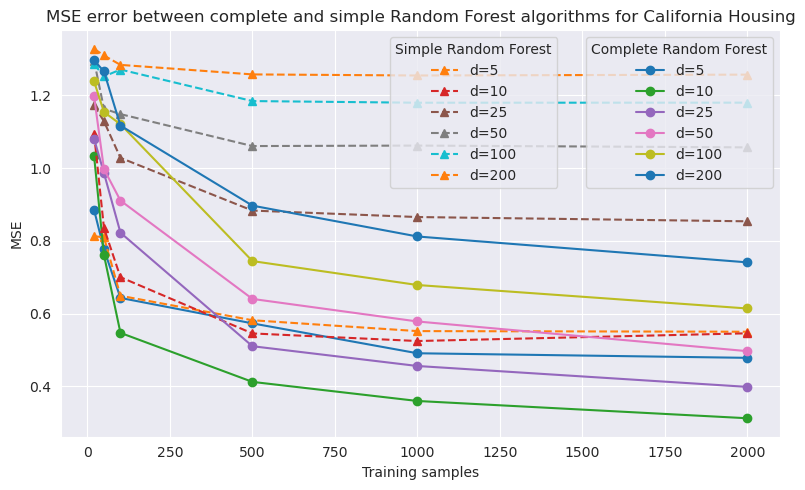

In [19]:
with open("california_housing_mse.pkl", "rb") as file:
    cal_results = pickle.load(file)

sklearn_res = cal_results["RF_sklearn"]
middle_res = cal_results["RF_simple"]

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(8,5))

# Lists to store handles (Line2D objects) for each method
lines_m1 = []
lines_m2 = []

for i, d_val in enumerate(variables):
    # Method 1, e.g. solid line + 'o' marker
    line_m1, = ax.plot(
        samples,                # x-axis
        sklearn_res[i, :],          # y-values for method1
        marker='o',
        linestyle='-', 
        label=f"d={d_val}"      # label will be used in the legend
    )
    
    # Method 2, e.g. dashed line + '^' marker
    line_m2, = ax.plot(
        samples,
        middle_res[i, :],
        marker='^',
        linestyle='--',
        label=f"d={d_val}"
    )
    
    lines_m1.append(line_m1)
    lines_m2.append(line_m2)

# Now create two separate legends:
#  1) For Method 1
legend_m1 = ax.legend(
    handles=lines_m1,
    labels=[f"d={val}" for val in variables],
    title="Complete Random Forest",
    loc="upper right"
)

# Add the first legend to the axes
ax.add_artist(legend_m1)

#  2) For Method 2
legend_m2 = ax.legend(
    handles=lines_m2,
    labels=[f"d={val}" for val in variables],
    title="Simple Random Forest",
    loc="upper right",
    bbox_to_anchor=(0.7, 1.0),
)

# Label axes, etc.
ax.set_xlabel("Training samples")
ax.set_ylabel("MSE")
ax.set_title("MSE error between complete and simple Random Forest algorithms for California Housing")

plt.tight_layout()
plt.savefig("img/california_housing_mse}.png")
plt.show()